# Test the pipeline with the Hungarian Kalman Filter (HKF).

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_kalman_filter import HungarianKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12


In [2]:
from scipy.special import factorial

def build_A_matrix(Dt, order):
    """Build state transition matrix A for a constant-jerk-like model of given order."""
    A = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        for j in range(i, order):
            A[i, j] = Dt**(j - i) / factorial(j - i)
    return A

def build_Q_matrix(dt, q, order):
    """Build process noise covariance matrix Q with reversed order (low-order terms in bottom-right)."""
    G = (dt ** np.arange(1, order + 1) / factorial(np.arange(1, order + 1)))[::-1].reshape(-1, 1)  # reverse and column
    Q = q**2 * (G @ G.T)
    return Q


def build_P_matrix(order, P_0_vector):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P = np.zeros((order, order), dtype=np.float64)
    for i in range(order):
        P[i, i] = P_0_vector[i] 
    return P

def evaluate_sources_rmse_gridsearch(
    Dts, qs, sigma_zs, P_0_vector, sources_train, sources_eval, selected, N_traces, ut="v1",
    order=3, batch_size=1, write_latex=False, latex_output_dir="output_2_traces/HKF/overlap_0",
    success_threshold=2.0
):
    """
    Perform grid search on training sources, and evaluate best config on separate evaluation sources.

    Parameters:
    - Dts, qs, sigma_zs (list): Grid values for Kalman filter parameters.
    - sources_train (list): Sources used during grid search.
    - sources_eval (list): Sources to evaluate success rate with best parameters.
    - selected (str): Identifier for source name formatting.
    - N_traces (int): Number of traces per image.
    - ut (str): Unique identifier for run.
    - order (int): State model order.
    - batch_size (int): Batch size for evaluation.
    - write_latex (bool): Whether to generate LaTeX tables.
    - latex_output_dir (str): Path to write LaTeX files.
    - success_threshold (float): RMSE threshold for a "success".

    Returns:
    - best_params (dict): Best parameter set.
    - best_success_rate_train (float): % success (per-curve) on training set.
    - success_rates_eval (list of float): % success (per-curve) per source in sources_eval.
    - results_table (dict): Grid result dictionary with (RMSE, std, success).
    """
    results_table = defaultdict(lambda: defaultdict(dict))
    min_success_rate = 0.0
    best_params = {}

    # -------- GRID SEARCH (on sources_train) --------
    for Dt in tqdm(Dts, desc="Dt"):
        for sigma_z in sigma_zs:
            for q in qs:
                A = build_A_matrix(Dt, order)
                Q = build_Q_matrix(Dt, q, order)
                P = build_P_matrix(order, P_0_vector)
                H = np.zeros((1, order), dtype=np.float64)
                H[0, 0] = 1
                R = np.array([[sigma_z**2]], dtype=np.float64)

                all_curve_rmses = []

                for source in sources_train:
                    image_folder_path = os.path.join(source, "signals")
                    GTs_folder_path = os.path.join(source, "ground_truth")

                    output_folder_path = None

                    _, _, curve_rmses = evaluate_filter(
                        image_folder_path, GTs_folder_path, output_folder_path,
                        HungarianKalmanFilter(A, H, Q, R),
                        P, batch_size=batch_size, step=1, save=False
                    )

                    all_curve_rmses.extend(curve_rmses)
                    # print("train, source:", source, "RMSE", np.mean(np.array(curve_rmses) <= success_threshold) * 100, np.array(curve_rmses) <= success_threshold)

                success_rate = np.mean(np.array(all_curve_rmses) <= success_threshold) * 100

                results_table[Dt][q][sigma_z] = success_rate

                if success_rate > min_success_rate:
                    min_success_rate = success_rate
                    best_params = {'Dt': Dt, 'q': q, 'sigma_z': sigma_z}

    # -------- FINAL EVALUATION on sources_eval with best params --------
    success_rates_eval = []
    if best_params:
        Dt, q, sigma_z = best_params['Dt'], best_params['q'], best_params['sigma_z']
        A = build_A_matrix(Dt, order)
        Q = build_Q_matrix(Dt, q, order)
        P = build_P_matrix(order, P_0_vector)
        H = np.zeros((1, order), dtype=np.float64)
        H[0, 0] = 1
        R = np.array([[sigma_z**2]], dtype=np.float64)

        for source in sources_eval:
            print(source)
            image_folder_path = os.path.join(source, "signals")
            GTs_folder_path = os.path.join(source, "ground_truth")

            output_folder_path = os.path.join(
                source,
                f"eval_HKF_dt{Dt:.2f}_q{q:.2f}_sigma_z{sigma_z:.2f}_order{order}_Ntraces{N_traces}_ut{ut}"
            )
            os.makedirs(output_folder_path, exist_ok=True)

            _, _, curve_rmses_eval = evaluate_filter(
                image_folder_path, GTs_folder_path, output_folder_path,
                HungarianKalmanFilter(A, H, Q, R),
                P, batch_size=batch_size, step=1
            )

            # print("eval, source:", source, "RMSE", np.mean(np.array(curve_rmses_eval) <= success_threshold) * 100, curve_rmses_eval)

            success_rate_eval = np.mean(np.array(curve_rmses_eval) <= success_threshold) * 100
            success_rates_eval.append(success_rate_eval)

    # -------- LaTeX TABLES (optional) --------
    if write_latex:
        os.makedirs(latex_output_dir, exist_ok=True)
        for Dt in Dts:
            latex = []
            latex.append(r"\begin{table}[H]")
            latex.append(r"\centering")
            latex.append(r"\begin{tabular}{c|" + "c" * len(sigma_zs) + "}")
            latex.append(r"$q \backslash \sigma_z$ & " + " & ".join([f"{sigma:.2f}" for sigma in sigma_zs]) + r"\\")
            latex.append(r"\hline")

            for q in qs:
                row = [f"{q:.2f}"]
                for sigma_z in sigma_zs:
                    entry = results_table[Dt][q].get(sigma_z, None)
                    if entry is not None:
                        success = entry
                        row.append(f"{success:.1f}\\%")
                    else:
                        row.append("-")
                latex.append(" & ".join(row) + r"\\")

            latex.append(r"\end{tabular}")
            latex.append(rf"\caption{{RMSE and success rate (≤ {success_threshold}) for Dt = {Dt:.2f}, ut = {ut}}}")
            latex.append(rf"\label{{tab:rmse_dt_{str(Dt).replace('.', '_')}_ut_{ut}}}")
            latex.append(r"\end{table}")

            file_path = os.path.join(latex_output_dir, f"RMSE_table_dt_{str(Dt).replace('.', '_')}_ut_{ut}.tex")
            with open(file_path, "w") as f:
                f.write("\n".join(latex))

        print(f"LaTeX tables written to {latex_output_dir}")

    return best_params, min_success_rate, success_rates_eval

In [3]:
sources_eval_sines_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-50"]

sources_eval_resampled_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_resampled_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_sines_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-50"]

sources_eval_dic = {
    "sources_eval_sines_2_curves": sources_eval_sines_2_curves,
    "sources_eval_resampled_2_curves": sources_eval_resampled_2_curves,
    "sources_eval_resampled_5_curves": sources_eval_resampled_5_curves,
    "sources_eval_sines_5_curves": sources_eval_sines_5_curves
}

In [4]:
overlaps = np.array([0.00, 0.06, 0.11, 0.17, 0.22, 0.28, 0.33, 0.39, 0.44, 0.50])
orders = [3, 4, 5]

success = np.zeros((len(overlaps), len(orders), 2)) # Shape (overlaps, num_methods, 1) 1 for sines

## Evaluate

### Parameters

In [5]:
Dts = [0.2] # [0.1, 0.5, 0.9]

qs = [0.1, 1, 1.5] # USER
sigma_zs = [0.1, 1, 4] # USER

# P_0_vector = [1, 10, 10]

batch_size = 5

N_traces = 2

ut = "grid_corect"

### 2 curves

In [6]:
for i, order in enumerate(orders):
    # USER
    P_0_vector = np.ones(order)
    for j in range(1, order): P_0_vector[j] = 10
    # USER

    print(f"Evaluating order {order}...")
    latex_output_dir = f"output_{N_traces}_traces_order_{order}"
    selected = r"\data_{}_traces".format(N_traces)
    sources_train = [
        r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines\overlap_0-28" # USER
    ]
    best_params, best_success_rate_train, success_rates_eval = evaluate_sources_rmse_gridsearch(
        Dts, qs, sigma_zs, P_0_vector,
        sources_train=sources_train,
        sources_eval=sources_eval_dic[r"sources_eval_sines_{}_curves".format(N_traces)] + sources_eval_dic[r"sources_eval_resampled_{}_curves".format(N_traces)],
        selected=selected,
        N_traces=N_traces,
        ut=ut,
        order=order,
        batch_size=batch_size,
        write_latex=True, 
        latex_output_dir=latex_output_dir,
        success_threshold=16.0 # USER
    )

    print("Best params:", best_params)
    print("Best success rate train:", f"{best_success_rate_train:.1f}%")
    print("Success rates eval:", success_rates_eval)
    print("\n\n\n")

    success[:, i, 0] = success_rates_eval[:len(overlaps)]
    success[:, i, 1] = success_rates_eval[len(overlaps):]

Evaluating order 3...


Dt: 100%|██████████| 1/1 [03:25<00:00, 205.97s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

Dt: 100%|██████████| 1/1 [03:44<00:00, 224.68s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

Dt: 100%|██████████| 1/1 [03:08<00:00, 188.47s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

PLOT

In [7]:
success.shape
print(success)

[[[100.  100. ]
  [100.  100. ]
  [100.  100. ]]

 [[ 50.  100. ]
  [ 75.  100. ]
  [ 80.  100. ]]

 [[ 35.   95. ]
  [ 60.   95. ]
  [ 60.   95. ]]

 [[ 40.  100. ]
  [ 62.5 100. ]
  [ 52.5 100. ]]

 [[ 25.   62.5]
  [ 32.5  62.5]
  [ 27.5  67.5]]

 [[ 35.   12.5]
  [ 62.5  17.5]
  [ 55.   22.5]]

 [[ 22.5   5. ]
  [ 37.5   5. ]
  [ 32.5   0. ]]

 [[ 32.5   5. ]
  [ 32.5  12.5]
  [ 30.   20. ]]

 [[ 40.    5. ]
  [ 27.5   5. ]
  [ 15.    7.5]]

 [[ 10.    0. ]
  [ 15.    0. ]
  [  5.    0. ]]]


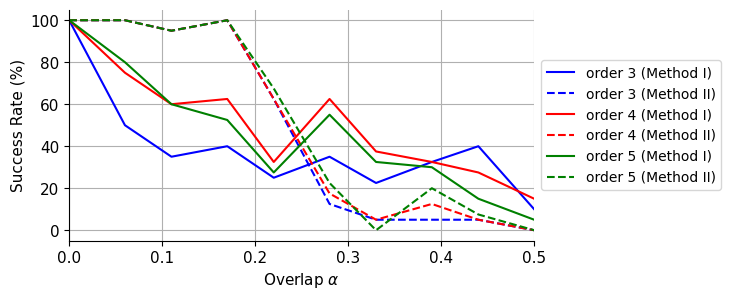

In [8]:
# Dark, bold tones
colors_dark = [
    "#8B0000",  # dark red
    "#004d00",  # deep green
    # "#00008B",  # dark blue
    "#4B0082",  # indigo
    "#5A4FCF"  # dark periwinkle
    # "#2F4F4F"   # dark slate gray
]

# Shiny, vibrant colors
colors_shiny = [
    "#FF4500",  # shiny orange-red
    "#00FF7F",  # spring green
    # "#1E90FF",  # dodger blue
    "#FF69B4",  # hot pink
    "#FFD700"  # gold
    # "#FF00FF"   # magenta
]

colors = ['b', 'r', 'g']

N_orders = success.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for i in range(N_orders):
    ax.plot(overlaps, success[:, i, 0], label=r"order {} (Method I)".format(orders[i]), color=colors[i])
    ax.plot(overlaps, success[:, i, 1], label=r"order {} (Method II)".format(orders[i]), color=colors[i], linestyle='--')
    # ax[i].plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color='red')
    # ax.plot(overlaps, success[:, idx, 0], label=orders[idx], linestyle="-", color='blue')
    # ax[i].plot(overlaps, success[:, idx, 1], label=labels[idx] + " (resampled)", linestyle="-.", color='blue')

# for i in range(success.shape[1]//2):
#     ax.plot(overlaps, success[:, i, 0], label=labels[i] + " (sines)", linestyle="-", color=colors_dark[i])
#     ax.plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color=colors_dark[i])
    
# for j in range(success.shape[1]//2):
#     i = j + success.shape[1]//2
#     ax.plot(overlaps, success[:, i, 0], label=labels[i] + " (sines)", linestyle="-", color=colors_shiny[j])
#     ax.plot(overlaps, success[:, i, 1], label=labels[i] + " (resampled)", linestyle="--", color=colors_shiny[j])

ax.set_ylabel("Success Rate (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(overlaps[0], overlaps[-1])
ax.set_xlabel(r"Overlap $\alpha$")


fig.savefig(f"HKF_{N_traces}_curvess_success_rate_vs_overlap_ut_{ut}.pdf", dpi=300, bbox_inches='tight', format='pdf')

### 5 curves

In [9]:
N_traces = 5

for i, order in enumerate(orders):
    # USER
    P_0_vector = np.ones(order)
    for j in range(1, order): P_0_vector[j] = 10
    # USER

    print(f"Evaluating order {order}...")
    latex_output_dir = f"output_{N_traces}_traces_order_{order}"
    selected = r"\data_{}_traces".format(N_traces)
    sources_train = [
        r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines\overlap_0-28" # USER
    ]
    best_params, best_success_rate_train, success_rates_eval = evaluate_sources_rmse_gridsearch(
        Dts, qs, sigma_zs, P_0_vector,
        sources_train=sources_train,
        sources_eval=sources_eval_dic[r"sources_eval_sines_{}_curves".format(N_traces)] + sources_eval_dic[r"sources_eval_resampled_{}_curves".format(N_traces)],
        selected=selected,
        N_traces=N_traces,
        ut=ut,
        order=order,
        batch_size=batch_size,
        write_latex=True, 
        latex_output_dir=latex_output_dir,
        success_threshold=6.0 # USER
    )

    print("Best params:", best_params)
    print("Best success rate train:", f"{best_success_rate_train:.1f}%")
    print("Success rates eval:", success_rates_eval)
    print("\n\n\n")

    success[:, i, 0] = success_rates_eval[:len(overlaps)]
    success[:, i, 1] = success_rates_eval[len(overlaps):]

Evaluating order 3...


Dt: 100%|██████████| 1/1 [03:07<00:00, 187.35s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

Dt: 100%|██████████| 1/1 [02:40<00:00, 160.96s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

Dt: 100%|██████████| 1/1 [02:43<00:00, 163.08s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-22
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-28
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-33
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-39
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-44
D:\Courses\Uclouvain\thesis\code\thes

In [10]:
print(success)

[[[ 80. 100.]
  [ 94. 100.]
  [ 93. 100.]]

 [[ 38. 100.]
  [ 70. 100.]
  [ 72. 100.]]

 [[ 26. 100.]
  [ 49. 100.]
  [ 51. 100.]]

 [[ 23. 100.]
  [ 31. 100.]
  [ 14. 100.]]

 [[ 11.  92.]
  [ 26.  96.]
  [  8.  93.]]

 [[  7.  76.]
  [ 24.  78.]
  [ 10.  82.]]

 [[ 14.  69.]
  [ 23.  75.]
  [  5.  67.]]

 [[ 10.  33.]
  [ 17.  44.]
  [  2.  27.]]

 [[  9.  11.]
  [  9.  16.]
  [  2.   5.]]

 [[  7.   0.]
  [ 10.   0.]
  [  0.   0.]]]


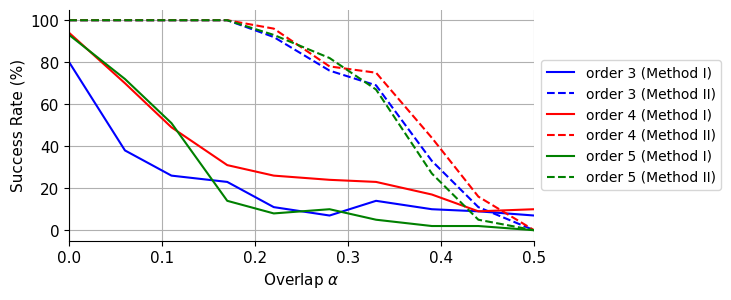

In [11]:
colors = ['b', 'r', 'g']

N_orders = success.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for i in range(N_orders):
    ax.plot(overlaps, success[:, i, 0], label=r"order {} (Method I)".format(orders[i]), color=colors[i])
    ax.plot(overlaps, success[:, i, 1], label=r"order {} (Method II)".format(orders[i]), color=colors[i], linestyle='--')

ax.set_ylabel("Success Rate (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(overlaps[0], overlaps[-1])
ax.set_xlabel(r"Overlap $\alpha$")

fig.savefig(f"HKF_{N_traces}_curvess_success_rate_vs_overlap_ut_{ut}.pdf", dpi=300, bbox_inches='tight', format='pdf')